# Le modèle SMA


***Importation des librairies***



In [ ]:
pip install mesa

     |████████████████████████████████| 655kB 5.4MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


In [ ]:
from mesa import Agent, Model
import random as rd
from numpy.random import choice

## Patient

Pour chaque patient on définit : 
- id : identité
- attente : temps d'attente primaire aux SUA
- CCMU   
- nb_operations   :  nombre total d'opérations à effectuer
- nb_restant  :  le nombre restant des tâches de soins à effectuer 
- taches  :  liste des tâches de soins (indexées par indices de capacités de soins nécessaires)



In [ ]:
class Patient(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.id = id
    self.attente_primaire = 0        # temps d'attente primaire

    # self.next_dispo = self.model.time
    self.ccmu = None

    self.nb_operations = None        # nombre d'opérations à effectuer
    self.nb_restant = None     # nombre restant d'opérations 
    self.taches = None         # liste des tâches de soins

  def score(self):
    """ Calcul du score du patient en se basant sur :
        - le ccmu
        - attente primaire du patient
        - rapport du nombre de thérapies restantes / nombre total de thérapies (afin de privilégier les patients qui 
        n'ont pas encore effectué aucune thérapie)
    """
    score = self.ccmu*((self.attente_primaire/60)**2)*(self.nb_restant/self.nb_operations)
    return score

## Agent identificateur 

Elle s'agit du médecin de diagnostic primaire

Pour chaque médecin, on définit:
- id   :   identité

On définit également les méthodes : 
- step : permet de prescrire la liste des traitement à effectuer au patient en cours 

NB : cette méthode est déclenché par l'Agent d'Accueil après l'enregistrement administratif du patient

In [ ]:
class Medecin(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.id = id

  def step(self, patient):
    """ Prescrire la liste des tâches de soins au patient en cours 
    """
    if patient.ccmu >= 3:
      nb_therapies = rd.randint(1, 2)
    else:
      nb_therapies = rd.randint(1, 4) # 1 à 4 opérations
       
    patient.nb_operations = nb_therapies
    patient.nb_restant = nb_therapies
    
    # prescription
    patient_therapies = rd.sample(range(0, self.model.nb_capacites), nb_therapies)
    patient_therapies.sort()  # trier par ordre de priorité 
    patient.taches = patient_therapies

    # fin du diagnotic 
    self.model.salle_attente2.append(patient)
    # print(f"patient {patient.id} est dans la salle d'attente secondaire")

## Agent d'Accueil

Il s'agit d'un agent IAO s'occupant de l'enregistrement administratif du patient

Pour un Agent d'Accueil, on définit:
- id  :  identité

On définit également les méthodes : 
- step : déclenchée à chaque tour afin d'enregistrer le patient et l'affecter à un Agent Identificateur (médecin)

In [ ]:
class IAO(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.id = id

  def step(self):
    """ Enregistrement administratif du patient  
    """
    self.fini = False
    for medecin in self.model.medecins:
      if self.model.salle_attente1:
        # reception du patient suivant 
        next_patient = self.model.salle_attente1[0]

        # affectation du ccmu
        next_patient.ccmu = choice([1, 2, 3, 4, 5], 1, [0.4, 0.5, 0.05, 0.03, 0.02])[0] # choice retourne un 'array' 
        self.model.salle_attente1.remove(next_patient)

        # passe le patient au médecin identificateur
        medecin.step(next_patient)
        


## Capacité de soin

Il s'agit d'une classe objet définie par : 
- id  : indice
- next_dispo  : prochaine disponibilité de la capacité
- duree  :   durée d'intervention nécessaire au traitement du patient

In [ ]:
class Capacite:
  def __init__(self, id, temps_capacité):
    self.id = id
    self.next_dispo = 0
  
    self.duree = temps_capacité

## Agent ordonnanceur

Il s'agit d'un agent complètement logiciel. On lui définit:
- id  : identité

On définit également les méthodes : 
- oper_finies : permet de s'assurer si les patients dans le bloc opératoire ont finis leurs tâches de soins en cours 



In [ ]:
class Ordonnanceur(Agent):
  def __init__(self, id, model):
    super().__init__(id, model)
    self.id = id

  def oper_finies(self):
    """ S'assurer si les patients dans le bloc opératoire ont finis leurs tâches de soins  en cours 
    """
    for capacite_index in range(len(self.model.bloc_oper)):
      patient_actuel = self.model.bloc_oper[capacite_index]

      if patient_actuel and self.model.capacites[capacite_index].next_dispo == self.model.time:
        # patient a fini son opération
        self.model.bloc_oper[capacite_index] = None  # personne n'est en traitement 
        patient_actuel.nb_restant -= 1        #  actualiser le nombre de thérapies restantes
         
        # le patient vient d'effectuer sa première tâche de soin
        if patient_actuel.nb_operations - patient_actuel.nb_restant ==1:
          # enregistrement du temps d'attente primaire du patient 
          self.model.attentes_primaire.append(patient_actuel.attente_primaire)
        
        # supprimer la tache effectuée de la liste des tâches de soins du patient
        del patient_actuel.taches[0]
        if patient_actuel.nb_restant != 0:
          # si le patient a encore des tâches de soins à affectuer 
          self.model.salle_attente2.append(patient_actuel)

  def step(self):
    prochaines_oper = {i:[] for i in range(self.model.nb_capacites)}
    # sortir les patients qui ont fini leurs thérapies du bloc opératoire 
    self.oper_finies()

    # indiquer les capacités dispo pour le prochain tour ainsi que les patients concernés
    if self.model.salle_attente2:
      for patient in self.model.salle_attente2:
        prochaine_tache = patient.taches[0]  # ainsi on garde toujours l'ordre de précédence des tâches de soins
        if self.model.bloc_oper[prochaine_tache] == None:
          # la tâche de soin est disponible pour accueillir de nouveaux patients
          prochaines_oper[prochaine_tache].append(patient)

    # faire passer les taches prioritaires
    for capacite_index in prochaines_oper:
      patients = prochaines_oper[capacite_index]
      if patients:
        # trier la liste des patients par score
        patients = sorted(patients, key = lambda patient:patient.score(), reverse = True)  # le plus grand score en premier 
        patient_prochain = patients[0]
        self.model.bloc_oper[capacite_index] = patient_prochain
        self.model.capacites[capacite_index].next_dispo = self.model.time  + self.model.capacites[capacite_index].duree
        # patient_prochain.next_dispo = self.model.capacites[capacite_index].next_dispo
        self.model.salle_attente2.remove(patient_prochain)
        tache = (patient_prochain.id, self.model.time, self.model.capacites[capacite_index].next_dispo)  # (patient, debut, fin)
        self.model.schedule[capacite_index].append(tache)

    #actualiser le temps d'attente des patients qui n'ont fait aucune consultation
    if self.model.salle_attente2:
      for patient in self.model.salle_attente2:
        if patient.nb_operations == patient.nb_restant: 
          patient.attente_primaire+=10

## le modèle

Notre modèle des urgences est défini par  :

***Paramètres*** 
- time  : temps actuel
- tours  : nombre de tours à exécuter
- last_patient  : id du dernier patient entré aux SUA

***Ressources*** 
- nb_capacites  : nombre de capacités de soins disponibles aux SUA
- capacités  :  liste des capacités disponibles aux SUA

- nb_medecins  :  nombre de médecins de diagnostic primaire (Agents Identificateurs)

- medecins   :  liste des médecins de diagnostic primaire (Agents Identificateurs) 

- iao  :  l'agent d'acceuil
- ordonnanceur : l'agent ordonnanceur
- salle_attente1  : salle d'attente 1 (primaire)
- salle_attente2  : salle d'attente 2 (secondaire)
- bloc_oper  :  bloc opératoire 
- attentes_primaire  : liste des attentes primaires de tous les patients aux SUA
- schedule :  agenda de passage des patients par les différentes tâches de soins 

On définit également les ***méthodes*** :
- newPatients  : ajout de nouveaux patients aux SUA à chaque tour 
- step  : déclenche step de l'iao afin de commencer l'enregistrement administratif des patients, ensuite déclenhe step de l'AO pour commencer l'ordonnancement
- run_model  : faire tourner le modèle pour un certain nombre de tour  



On cherche ici à produire la solution d'ordonnancement sur une journée normale aux SUA, avec une moyenne de 175 arrivées en 24h.

In [ ]:
nb_capacites = 10
nb_medecins = 3 
nb_tours = 58 # prédiction d'une moyenne de 175 arrivées chaque jour au CHU de Lille: 58*3 = 174 patients


class Urgences(Model):
  def __init__(self):
    self.time =0
    self.tours = nb_tours
    self.last_patient = 0

    self.nb_capacites =  nb_capacites
    # temps nécessaire de traitement pour chaque capacité disponible (en minutes)
    temps_capacité = [40, 20, 10, 30, 40, 30, 40, 20, 20, 50]
    self.capacites = [Capacite(i, temps_capacité[i]) for i in range(self.nb_capacites)]

    self.nb_medecins = nb_medecins
    self.medecins = [Medecin(i, self) for i in range(self.nb_medecins)]

    self.iao = IAO(0, self)
    self.ordonnanceur = Ordonnanceur(0, self)

    self.salle_attente1 = []    # [patient, patient, ...]
    self.salle_attente2 = []   # [patient, patient, ...]
    
    self.bloc_oper = [None for _ in range(self.nb_capacites)]     # [patient, patient, ...]

    self.attentes_primaire = []
    self.schedule = [[] for _ in range(self.nb_capacites)]


  def newPatients(self):
    """ Ajout de nouveaux patients aux SUA à chaque tour 
    """
    nb_patients = 3

    for i in range(nb_patients):
      id = self.last_patient + i
      patient = Patient(id, self)
      patient.ccmu = choice([1, 2, 3, 4, 5], 1, [0.4, 0.5, 0.05, 0.03, 0.02])[0] 
      self.salle_attente1.append(patient)
    self.last_patient += nb_patients 

  def step(self):
    self.iao.step()
    self.ordonnanceur.step()

  def run_model(self):
    for i in range(self.tours):
      self.newPatients()  # entrée de 3 patients 
      self.step()
      self.time += 10

    #print("fin des tours !")

    while self.bloc_oper != [None for _ in range(self.nb_capacites)]:
      #print("    ordonnancement en cours ....")
      self.ordonnanceur.step()
      self.time += 10

    #print("c'est fini !")
    return self.schedule

In [ ]:
modele = Urgences()
schedule = modele.run_model()
modele.last_patient

174

In [ ]:
# temps d'attente primaire moyen des patients

sum =0
for attente in modele.attentes_primaire:
      sum += attente

sum/modele.last_patient

121.66666666666667

On obtient généralement un temps d'attente primaire moyen entre 90 minutes (1h 30min) et 140 minutes (2h 10 min).

On a besoin de convertir le temps en minutes au format "hh:mm:ss".

In [ ]:
# formattage de temps

def format_time(time):
  heures = 0
  minutes = 0
  while time >= 60:
    heures +=1
    time -= 60
  minutes = time

  if heures < 10:
    heures = "0" + str(heures) +":"
  else:
    heures = str(heures)+":"

  if minutes < 10:
    minutes = "0" + str(minutes) +":00"
  else:
    minutes = str(minutes)+":00"
  return heures+minutes

***Diagramme de Gantt***

In [ ]:
# import plotly.express as px
import pandas as pd
import plotly.figure_factory as ff
import numpy as nb

data_frame = []

for machine_index in range(len(schedule)):
  taches = schedule[machine_index]
  if taches:
    for tache in taches:
      patient_id, debut, fin = tache[0], format_time(tache[1]), format_time(tache[2])
      data_frame.append(
          dict(Task= "Capacité "+str(machine_index+1), Start = '2020-10-22 '+debut, Finish = '2020-10-22 '+fin, Resource = "Patient "+str(patient_id))
      )

# créer une figure
# colors = {'Machine 0': '#ff7f0e','Machine 1': '#1f77b4','Machine 2': '#d62728','Machine 3': '#2ca02c'}
import matplotlib.cm as cm
# colors = cm.rainbow(np.linspace(0, 1,modele.last_patient))
number_of_colors = modele.last_patient

#color = ["#"+''.join([rd.choice('0123456789ABCDEF') for j in range(6)])
             #for i in range(number_of_colors)]

color = ["#"+''.join(rd.sample('0123456789ABCDEF', 6) )
             for i in range(number_of_colors)]
dict_colors = {}
for i in range(number_of_colors):
  dict_colors["Patient "+str(i)] = color[i]

fig = ff.create_gantt(data_frame, colors=dict_colors, index_col='Resource', show_colorbar=True,group_tasks=True)
# fig = create_gantt(data_frame)
fig.show()

L'ordonnancement des tâches de soins est assez optimal en termes de temps d'attente primaire des patients, de la distribution de charge sur les tâches de soin, tout en respectant l'ordre de précédence des tâches de soins des patients.

Par la suite, on produira cette solution (une solution calculée sur une journée) sur une durée de ***365 jours = 1 an***, afin de calculer le temps d'attente primaire moyen des patients sur cette période.

(array([ 52., 120., 113.,  58.,  17.,   3.,   1.,   0.,   0.,   1.]),
 array([ 73.44827586,  97.66666667, 121.88505747, 146.10344828,
        170.32183908, 194.54022989, 218.75862069, 242.97701149,
        267.1954023 , 291.4137931 , 315.63218391]),
 <a list of 10 Patch objects>)

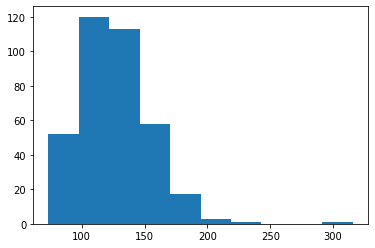

In [ ]:
# moeyenne sur un mois
import matplotlib.pyplot as plt

iterations = 365
moyennes = []
for i in range(iterations):
  modele = Urgences()
  schedule = modele.run_model()
  sum =0
  for attente in modele.attentes_primaire:
    sum += attente
  average = sum/modele.last_patient
  moyennes.append(average)

plt.hist(moyennes)
 

On constate alors une distribution assez optimale des temps d'attente primaire des patients, avec une moyenne de ***127 minutes = 2h 6minutes.***